In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

pd.options.mode.chained_assignment = None  # Suppress the warning

Read the data for Temperature, Stirring, Feed of Glucose, Base, Acid, dissolved O2, ph, air feed and Offgas

In [3]:
df_T=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
df_base=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
df_acid=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
df_air=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
df_offgas=pd.read_excel('data/fermentation raw data/offgas_data.xlsx')

In [4]:
# group the dataframes -- acid and base will be pre-processed differently
first_para=[df_T, df_stir, df_feed1, df_pO2, df_pH, df_air]
second_para=[df_base, df_acid]

In [5]:
start = '31-05-2023 10:14:00'
end = '02-06-2023 08:22:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [6]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
df_merged1=pd.DataFrame()
for df in first_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').mean() # could be changed to sum/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged1.empty:
        df_merged1=df_se
    else:
        df_merged1=df_merged1.merge(df_se, on='DateTime', how='inner')

In [7]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
# since the feed of base/acid lasts only 5s, data will be lost if we take the first value
## instead we take the sum of the values within that minute and then later divide it by (5/60)
df_merged2=pd.DataFrame()
for df in second_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').sum() # could be changed to sum/mean/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged2.empty:
        df_merged2=df_se
    else:
        df_merged2=df_merged2.merge(df_se, on='DateTime', how='inner')

In [8]:
# merging the 2 dataframes
df_merged3 = df_merged1.copy()
df_merged3 = df_merged3.merge(df_merged2, on='DateTime', how='inner')

Merge offgas to the other parameters.

In [9]:
# offgas values are saved in another dataframe
## same preprocessing as the others

# methanol is zero for the whole time period and RMS is not needed
## ethanol has 30 not zero values but the highest is 0.0001 %
df_offgas.drop(['offg_ethanol', 'offg_methanol', 'offg_RMS'], axis=1, inplace=True) #
# reduce sample frequency to 1min which makes the merge easier
## mean value of each minute is taken
df_offgas.set_index('Timestamp', inplace=True)
df_resampled = df_offgas.resample('1T').mean() # could be changed to sum/mean/first/min/max...
df_resampled.reset_index(drop=False, inplace=True)
df_resampled.rename(columns={'Timestamp': 'DateTime'}, inplace=True)

# dataframe is reduced to the start and end time of the fermentation
df_offg=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
# df_offg['sum']=df_offg[['offg_co2', 'offg_n2', 'offg_o2']].sum(axis=1)
# df_offg['y_CO2']=df_offg['offg_co2']/df_offg['sum']
# df_offg['y_O2']=df_offg['offg_co2']/df_offg['sum']
# df_offg['y_N2']=df_offg['offg_co2']/df_offg['sum']

In [10]:
df_offg.describe()

,DateTime,offg_co2,offg_n2,offg_o2
count,2767,2767.000000,2767.000000,2767.000000
mean,2023-06-01 09:18:00,0.927705,77.329306,20.299835
min,2023-05-31 10:15:00,0.039070,77.159634,19.113743
25%,2023-05-31 21:46:30,0.399840,77.261504,19.502416
50%,2023-06-01 09:18:00,0.486723,77.352880,20.702242
75%,2023-06-01 20:49:30,1.784837,77.380780,20.787459
max,2023-06-02 08:21:00,2.117136,77.562147,21.184786
std,NaN,0.684011,0.074940,0.637764


In [11]:
# add process duration in hours as time [h]
df_merged4=df_merged3.merge(df_offg, on='DateTime', how='inner')
first_timestamp = df_merged4['DateTime'].iloc[0]  # Get the first timestamp
df_merged4['time [h]'] = (df_merged4['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_merged4['time [h]'] = df_merged4['time [h]'].round(2)
df_merged4.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'pO₂ Value (pO₂)': 'DO2 [%]'}, errors='raise', inplace=True)
df_merged4.rename(columns={'offg_co2': 'Offgas CO2 [%]', 'offg_n2': 'Offgas N2 [%]', 'offg_o2': 'Offgas O2 [%]'}, errors='raise', inplace=True)
df_merged4.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,77.497645,21.178897,0.0


Merge biomass to the other parameters.

In [12]:
df_biomass=pd.read_csv('data/fermentation raw data/biomass_DW.csv', sep=';')
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'duration [h]': 'time [h]', 'biomass (g/L)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(1)

,Biomass [g/L],time [h]
0,0.7,0.2


Merge HPLC data for glucose, lactic acid, acetic acid and ehtanol to other paramters.

In [13]:
df_hplc = pd.read_excel('data/fermentation raw data/HPLC.xlsx')
for col in df_hplc.columns:
    df_hplc[col] = df_hplc[col].astype(str).str.replace(',', '.')
    df_hplc[col] = pd.to_numeric(df_hplc[col])
df_hplc.rename(columns={'Time [h]': 'time [h]'}, inplace=True)
df_hplc.head(23)

,time [h],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L]
0,0.20,5.220,0.167,0.037,0.007,0.079
1,2.10,5.176,0.160,0.027,0.033,0.104
2,2.30,5.198,0.118,0.040,0.002,0.334
3,3.40,4.685,0.141,0.041,0.006,0.357
4,4.40,4.230,0.187,0.044,0.024,0.148
5,5.35,3.480,0.210,0.041,0.058,0.146
6,6.35,2.881,0.276,0.043,0.122,0.128
7,7.30,2.018,0.381,0.005,0.230,0.141
8,8.30,1.567,0.467,0.003,0.339,0.100
9,9.30,1.041,0.429,0.003,0.390,0.156


In [14]:
# add Yield Yxs calculated stepwise: consecutive between the two closest taken sample such as 1&2, 2&3, 3&4,... (?) 
df_Yxs = df_biomass.merge(df_hplc, on='time [h]', how='left')

#this way i tried to calculated it always outgoing from the first sample data to the next one. 1 to 2, 1 to 3, 1 to 4... 
df_Yxs['mu [1/h]'] = ((np.log(df_Yxs['Biomass [g/L]'] - np.log(df_Yxs['Biomass [g/L]'].iloc[0]))) / df_Yxs['time [h]'] - df_Yxs['time [h]'].iloc[0])*(-1)
# df_Yxs['mu [1/h]'] = np.log(df_Yxs['Biomass [g/L]'].diff()) / df_Yxs['time [h]'].diff()

df_Yxs['Yxs [gx/gs]'] = df_Yxs['Biomass [g/L]'].diff() / df_Yxs['Glucose [g/L]'].diff()*(-1)
 # df_Yxs['Yxs [gx/gs]'] = (df_Yxs['Biomass [g/L]'] - df_Yxs['Biomass [g/L]'].iloc[0]) / (df_Yxs['Glucose [g/L]'] - df_Yxs['Glucose [g/L]'].iloc[0])

# Save the DataFrame to an Excel file
#df_Yxs.to_excel('data/Yxs_table.xlsx', index=False)

df_Yxs.head(20)


,Biomass [g/L],time [h],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L],mu [1/h],Yxs [gx/gs]
0,0.70,0.2,5.220,0.167,0.037,0.007,0.079,-0.075636,NaN
1,1.30,2.1,5.176,0.160,0.027,0.033,0.104,-0.040387,13.636364
2,1.54,2.3,5.198,0.118,0.040,0.002,0.334,-0.078305,-10.909091
3,1.16,3.4,4.685,0.141,0.041,0.006,0.357,0.077494,-0.740741
4,1.78,4.4,4.230,0.187,0.044,0.024,0.148,0.027443,1.362637
5,2.51,5.4,NaN,NaN,NaN,NaN,NaN,0.004972,NaN
6,3.15,6.4,NaN,NaN,NaN,NaN,NaN,0.003958,NaN
7,4.90,7.3,2.018,0.381,0.005,0.230,0.141,-0.027329,NaN
8,5.34,8.3,1.567,0.467,0.003,0.339,0.100,-0.009624,0.975610
9,5.50,9.3,1.041,0.429,0.003,0.390,0.156,0.009937,0.304183


In [15]:
log_values = np.log(df_Yxs['Biomass [g/L]'])
print(log_values)

0    -0.356675
1     0.262364
2     0.431782
3     0.148420
4     0.576613
5     0.920283
6     1.147402
7     1.589235
8     1.675226
9     1.704748
10    2.170196
11    2.032088
12    1.981001
13    1.985131
14    1.894617
15    1.921325
16    1.888584
17    2.300583
18    2.323368
19    3.142427
Name: Biomass [g/L], dtype: float64


In [16]:
df = df_merged4.merge(df_Yxs, on='time [h]', how='left')
df.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],...,Offgas O2 [%],time [h],Biomass [g/L],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L],mu [1/h],Yxs [gx/gs]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,...,21.178897,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Final dataframe created. Now, preprocessing and adding parameters:

In [17]:
# the peak around the 7th hour was not fed into the batch but just to accumulate the glucose in the pipe
df.loc[df.index[428:431], 'Feed 1 Value (%)'] = 0

# after 34 h the Glucose feed was most likely empty but it was still measured as feeding
df.loc[df['time [h]'] > 34, 'Feed 1 Value (%)'] = 0
df['Feed 1 Value (%)']=df['Feed 1 Value (%)']/(10*1000)
df.rename(columns={'Feed 1 Value (%)': 'Glucose feed [L/min]'}, inplace=True)

In [18]:
# one feed of base/acid lasts for max 5s. Since we have samples every minute I divided the value of the feed rate by 12 because I multiply by 5s*1/60s
df['Pump - Base Value (%)']=df['Pump - Base Value (%)']/(40*10*1000)
df['Pump - Acid Value (%)']=df['Pump - Acid Value (%)']/(40*10*1000)
df.rename(columns={'Pump - Base Value (%)': 'Pump - Base [L/min]', 'Pump - Acid Value (%)': 'Pump - Acid [L/min]', 'Flow - Air Value': 'Air feed [mL/min]'}, inplace=True)

# Cumulative Base Feed
df['Cum. Base feed [L/min]']=df['Pump - Base [L/min]'].cumsum()
df['Cum. Acid feed [L/min]']=df['Pump - Acid [L/min]'].cumsum()

df['Air feed [mL/min]']=df['Air feed [mL/min]']/(10)

In [19]:
df['Offgas CO2 [mL/min]']=df['Air feed [mL/min]'] * df['Offgas CO2 [%]']/100
df['Offgas O2 [mL/min]']=df['Air feed [mL/min]'] * df['Offgas O2 [%]']/100
df['Offgas N2 [mL/min]']=df['Air feed [mL/min]'] * df['Offgas N2 [%]']/100

Volume calculation is incomplete!!! - reduction bz sampling is missing

In [20]:
# since the fermentation is fed-batch, the volume increases with time
df['Feed total [L/min]']=df['Glucose feed [L/min]']+df['Pump - Base [L/min]']+df['Pump - Acid [L/min]']
df['Volume [L]']=df['Feed total [L/min]'].cumsum().add(1)

# Feed 1 contains 350 g/L glucose so a new parameter with the feed rate in g/h is added
df['Glucose feed [g/h]']=df['Glucose feed [L/min]']*350*60

# dissolved oxygen, stirring and the temperature fluctuate a lot so exponential smooting is applied
df['DO2 [%]- smoothed']=df['DO2 [%]'].ewm(alpha=0.1).mean()
df['Stirring [rpm]- smoothed']=df['Stirrer [rpm]'].ewm(alpha=0.1).mean()
df['T [°C]- smoothed']=df['Temperature [°C]'].ewm(alpha=0.1).mean()

In [21]:
df['OUR [%/L/h]'] = ((df['Offgas O2 [%]']-df['Offgas O2 [%]'][0])/df['Volume [L]'])/(df['time [h]'])
df['CER [%/L/h]'] = ((df['Offgas CO2 [%]']-df['Offgas CO2 [%]'][0])/df['Volume [L]'])/(df['time [h]'])
df['RQ'] = df['CER [%/L/h]'] / df['OUR [%/L/h]']*(-1)
df.head()

,DateTime,Temperature [°C],Stirrer [rpm],Glucose feed [L/min],DO2 [%],pH Value (pH),Air feed [mL/min],Pump - Base [L/min],Pump - Acid [L/min],Offgas CO2 [%],...,Offgas N2 [mL/min],Feed total [L/min],Volume [L],Glucose feed [g/h],DO2 [%]- smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed,OUR [%/L/h],CER [%/L/h],RQ
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.02250,0.1,0.0,0.0,0.039070,...,0.077498,0.0,1.0,0.0,72.283333,293.464167,29.869167,NaN,NaN,NaN
1,2023-05-31 10:16:00,29.863333,293.145833,0.0,65.328750,7.02000,0.1,0.0,0.0,0.039194,...,0.077496,0.0,1.0,0.0,68.623026,293.296623,29.866096,-0.013956,0.006204,0.444548
2,2023-05-31 10:17:00,29.827500,293.525833,0.0,58.371111,7.01125,0.1,0.0,0.0,0.039268,...,0.077511,0.0,1.0,0.0,64.840032,293.381202,29.851854,-0.134719,0.006604,0.049023
3,2023-05-31 10:18:00,29.762727,293.107273,0.0,51.463750,7.01000,0.1,0.0,0.0,0.039736,...,0.077513,0.0,1.0,0.0,60.950447,293.301548,29.825938,-0.135551,0.013322,0.098284
4,2023-05-31 10:19:00,29.820833,292.355000,0.0,52.295556,7.00500,0.1,0.0,0.0,0.041027,...,0.077511,0.0,1.0,0.0,58.836972,293.070407,29.824691,-0.079205,0.027953,0.352917


Evaporation feed

In [22]:

df['F_evap [kg/h]'] = (df['Air feed [mL/min]']*60/100)*(0.0235*3294) - 0.65 # carolines euqation, question mark is just the concentration of water that goes in (last term)
df.head()

,DateTime,Temperature [°C],Stirrer [rpm],Glucose feed [L/min],DO2 [%],pH Value (pH),Air feed [mL/min],Pump - Base [L/min],Pump - Acid [L/min],Offgas CO2 [%],...,Feed total [L/min],Volume [L],Glucose feed [g/h],DO2 [%]- smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed,OUR [%/L/h],CER [%/L/h],RQ,F_evap [kg/h]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.02250,0.1,0.0,0.0,0.039070,...,0.0,1.0,0.0,72.283333,293.464167,29.869167,NaN,NaN,NaN,3.99454
1,2023-05-31 10:16:00,29.863333,293.145833,0.0,65.328750,7.02000,0.1,0.0,0.0,0.039194,...,0.0,1.0,0.0,68.623026,293.296623,29.866096,-0.013956,0.006204,0.444548,3.99454
2,2023-05-31 10:17:00,29.827500,293.525833,0.0,58.371111,7.01125,0.1,0.0,0.0,0.039268,...,0.0,1.0,0.0,64.840032,293.381202,29.851854,-0.134719,0.006604,0.049023,3.99454
3,2023-05-31 10:18:00,29.762727,293.107273,0.0,51.463750,7.01000,0.1,0.0,0.0,0.039736,...,0.0,1.0,0.0,60.950447,293.301548,29.825938,-0.135551,0.013322,0.098284,3.99454
4,2023-05-31 10:19:00,29.820833,292.355000,0.0,52.295556,7.00500,0.1,0.0,0.0,0.041027,...,0.0,1.0,0.0,58.836972,293.070407,29.824691,-0.079205,0.027953,0.352917,3.99454


In [23]:
# the total volume in the end of the fermentation is compared with the experimental data
df['Volume [L]'].max()

2.4677710560606094

In [24]:
df.sort_index(axis=1, inplace=True)

In [25]:
# save dataframe as csv and xlsx files
df.to_csv('data/data_combined.csv')
df.to_excel('data/data_combined.xlsx')

In [26]:
df.columns

Index(['Acetic acid [g/L]', 'Air feed [mL/min]', 'Biomass [g/L]',
       'CER [%/L/h]', 'Cum. Acid feed [L/min]', 'Cum. Base feed [L/min]',
       'DO2 [%]', 'DO2 [%]- smoothed', 'DateTime', 'Ethanol [g/L]',
       'F_evap [kg/h]', 'Feed total [L/min]', 'Glucose [g/L]',
       'Glucose feed [L/min]', 'Glucose feed [g/h]', 'Glycerol [g/L]',
       'Lactic acid [g/L]', 'OUR [%/L/h]', 'Offgas CO2 [%]',
       'Offgas CO2 [mL/min]', 'Offgas N2 [%]', 'Offgas N2 [mL/min]',
       'Offgas O2 [%]', 'Offgas O2 [mL/min]', 'Pump - Acid [L/min]',
       'Pump - Base [L/min]', 'RQ', 'Stirrer [rpm]',
       'Stirring [rpm]- smoothed', 'T [°C]- smoothed', 'Temperature [°C]',
       'Volume [L]', 'Yxs [gx/gs]', 'mu [1/h]', 'pH Value (pH)', 'time [h]'],
      dtype='object')

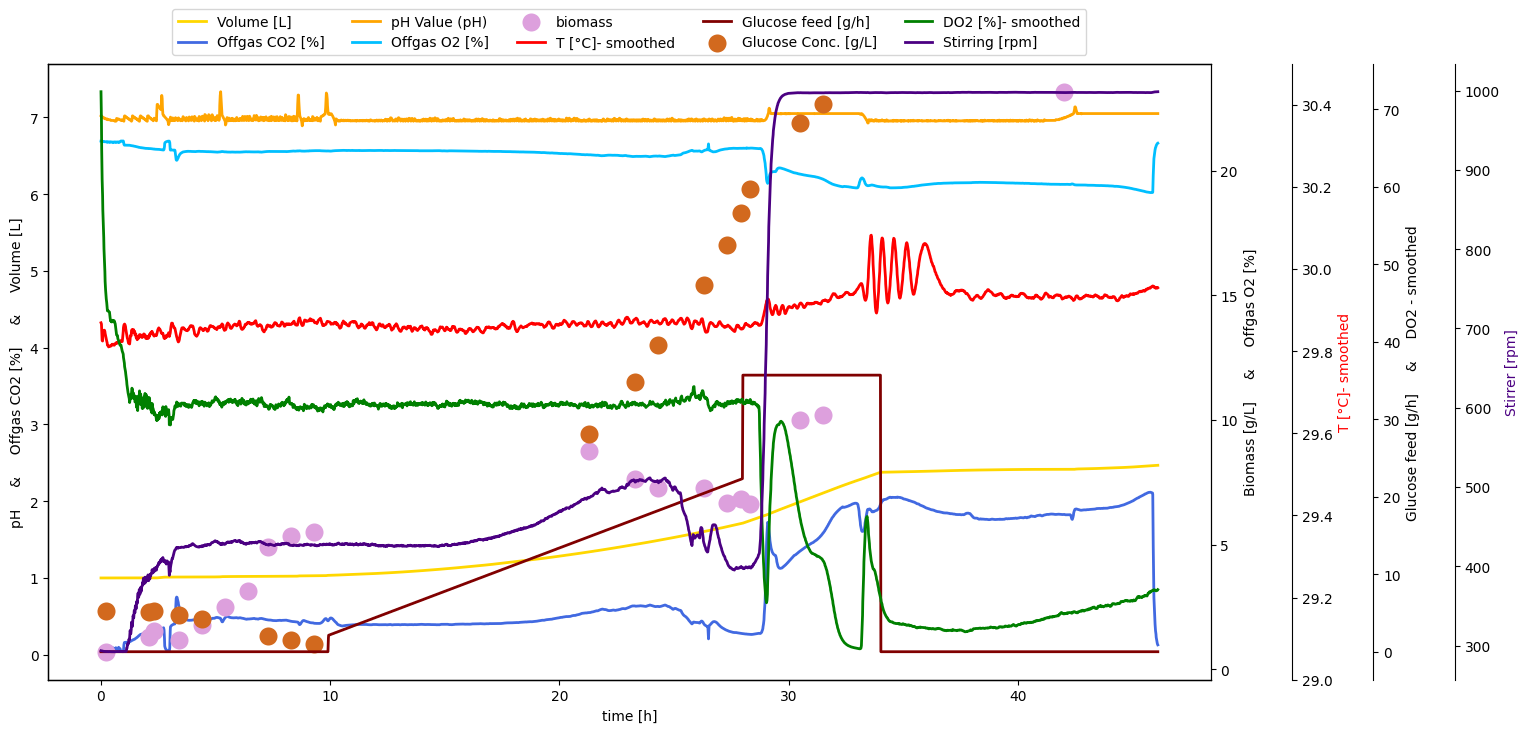

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax_2nd=ax.twinx()
ax_3rd=ax.twinx()
ax_4th=ax.twinx()
ax_5th=ax.twinx()

ax_5th.plot(df['time [h]'], df['Stirring [rpm]- smoothed'], label='Stirring [rpm]', color='indigo', linewidth=2)
ax_4th.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon', linewidth=2)
ax_4th.scatter(df['time [h]'], df['Glucose [g/L]'], label='Glucose Conc. [g/L]', linewidth=7, color='chocolate')
ax_4th.plot(df['time [h]'], df['DO2 [%]- smoothed'], label='DO2 [%]- smoothed', color='green', linewidth=2)
ax_3rd.plot(df['time [h]'], df['T [°C]- smoothed'], label='T [°C]- smoothed', color='red', linewidth=2)
ax_3rd.set_ylim(29,30.5)
ax_2nd.plot(df['time [h]'], df['Offgas O2 [%]'], label='Offgas O2 [%]', color='deepskyblue', linewidth=2)
ax.plot(df['time [h]'], df['Volume [L]'], label='Volume [L]', color='gold', linewidth=2)
ax.plot(df['time [h]'], df['Offgas CO2 [%]'], label='Offgas CO2 [%]', color='royalblue', linewidth=2)
ax.plot(df['time [h]'], df['pH Value (pH)'], label='pH Value (pH)', color='orange', linewidth=2)
#ax.plot(df['time [h]'], df['Air feed [mL/min]'], label='Flow - Air Value', color='aqua', linewidth=2)
ax_2nd.scatter(df['time [h]'], df['Biomass [g/L]'], linewidth=7, color='plum', label='biomass')

ax_3rd.spines.right.set_position(("axes", 1.07))
ax_4th.spines.right.set_position(("axes", 1.14))
ax_5th.spines.right.set_position(("axes", 1.21))

ax.set_xlabel('time [h]')
ax.set_ylabel('pH     &     Offgas CO2 [%]     &     Volume [L]') #     Flow - Air     &, color='orange'
ax_2nd.set_ylabel('Biomass [g/L]     &     Offgas O2 [%]') #, color='royalblue'
ax_3rd.set_ylabel('T [°C]- smoothed', color='red')
ax_4th.set_ylabel('Glucose feed [g/h]     &     DO2 - smoothed') #, color='green'
ax_5th.set_ylabel('Stirrer [rpm]', color='indigo')

# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()
handles_4th, labels_4th = ax_4th.get_legend_handles_labels()
handles_5th, labels_5th = ax_5th.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd + handles_3rd + handles_4th + handles_5th
all_labels = labels + labels_2nd + labels_3rd + labels_4th + labels_5th

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)

plt.show()

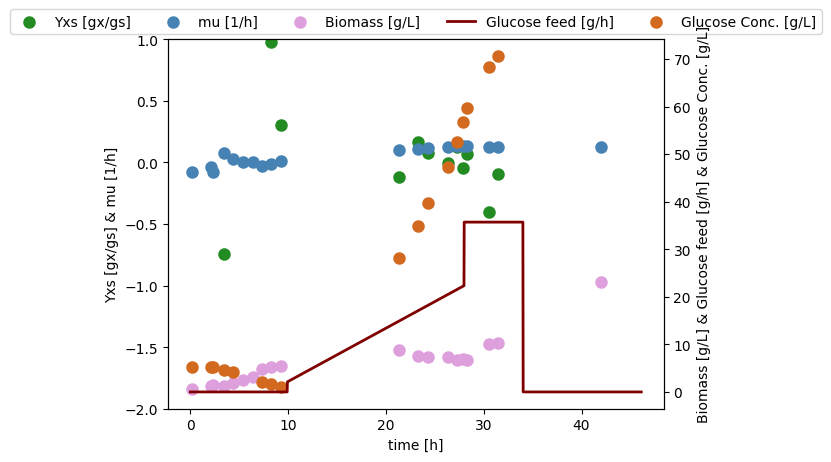

In [28]:
fig, ax = plt.subplots()
ax_2nd=ax.twinx()
#ax_3rd=ax.twinx()

ax.scatter(df['time [h]'], df['Yxs [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=3)
ax.scatter(df['time [h]'], df['mu [1/h]'], label='mu [1/h]', color='steelblue', linewidth=3)
ax.set_ylim(-2,1)
ax_2nd.scatter(df['time [h]'], df['Biomass [g/L]'], label='Biomass [g/L]', color='plum', linewidth=3)
ax_2nd.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon', linewidth=2)
ax_2nd.scatter(df['time [h]'], df['Glucose [g/L]'], label='Glucose Conc. [g/L]', color='chocolate', linewidth=3)
#ax_3rd.spines.right.set_position(("axes", 1.15))

ax.set_xlabel('time [h]')
ax.set_ylabel('Yxs [gx/gs] & mu [1/h]')
ax_2nd.set_ylabel('Biomass [g/L] & Glucose feed [g/h] & Glucose Conc. [g/L]')
#ax_3rd.set_ylabel('Glucose feed [g/h] & Glucose Conc. [g/L]')

handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
#handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd # + handles_3rd
all_labels = labels + labels_2nd # + labels_3rd

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)
plt.show()

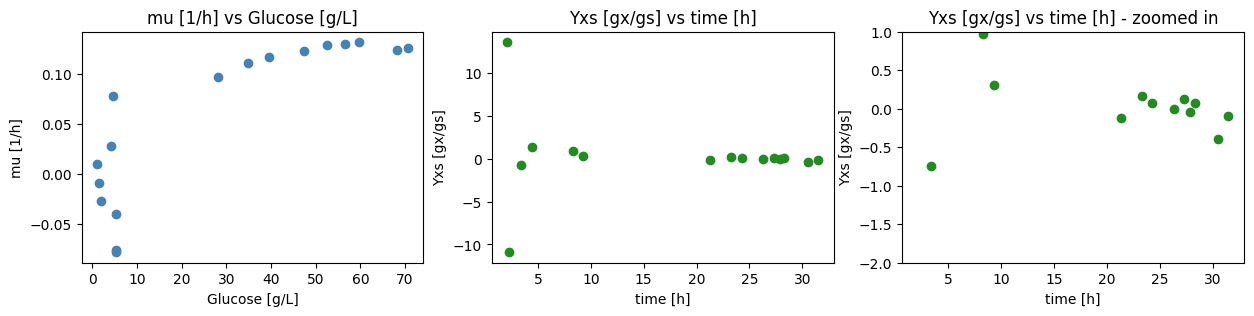

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))

ax[0].scatter(df['Glucose [g/L]'], df['mu [1/h]'], label='mu [1/h]', color='steelblue', linewidth=1)
ax[1].scatter(df['time [h]'], df['Yxs [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)
ax[2].scatter(df['time [h]'], df['Yxs [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)
ax[2].set_ylim(-2, 1)

ax[0].set_xlabel('Glucose [g/L]')
ax[0].set_ylabel('mu [1/h]')
ax[1].set_xlabel('time [h]')
ax[1].set_ylabel('Yxs [gx/gs]')
ax[2].set_xlabel('time [h]')
ax[2].set_ylabel('Yxs [gx/gs]')

ax[0].set_title('mu [1/h] vs Glucose [g/L]')
ax[1].set_title('Yxs [gx/gs] vs time [h]')
ax[2].set_title('Yxs [gx/gs] vs time [h] - zoomed in')
plt.show()

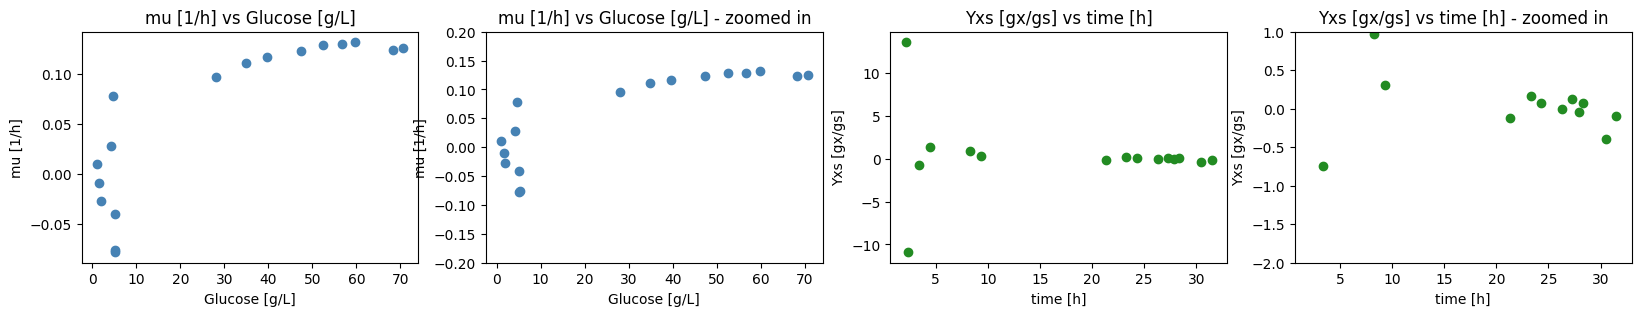

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))

ax[0].scatter(df['Glucose [g/L]'], df['mu [1/h]'], label='mu [1/h]', color='steelblue', linewidth=1)
ax[1].scatter(df['Glucose [g/L]'], df['mu [1/h]'], label='mu [1/h]', color='steelblue', linewidth=1)
ax[1].set_ylim(-0.2, 0.2)
ax[2].scatter(df['time [h]'], df['Yxs [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)
ax[3].scatter(df['time [h]'], df['Yxs [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)
ax[3].set_ylim(-2, 1)

ax[0].set_xlabel('Glucose [g/L]')
ax[0].set_ylabel('mu [1/h]')
ax[1].set_xlabel('Glucose [g/L]')
ax[1].set_ylabel('mu [1/h]')
ax[2].set_xlabel('time [h]')
ax[2].set_ylabel('Yxs [gx/gs]')
ax[3].set_xlabel('time [h]')
ax[3].set_ylabel('Yxs [gx/gs]')

ax[0].set_title('mu [1/h] vs Glucose [g/L]')
ax[1].set_title('mu [1/h] vs Glucose [g/L] - zoomed in')
ax[2].set_title('Yxs [gx/gs] vs time [h]')
ax[3].set_title('Yxs [gx/gs] vs time [h] - zoomed in')
plt.show()

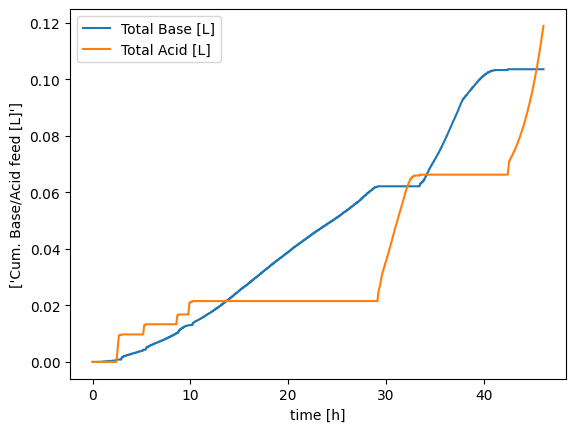

In [31]:
fig, ax = plt.subplots()

ax.plot(df['time [h]'], df[['Cum. Base feed [L/min]', 'Cum. Acid feed [L/min]']], label=['Total Base [L]', 'Total Acid [L]'])

ax.set_xlabel('time [h]')
ax.set_ylabel(['Cum. Base/Acid feed [L]'])
ax.legend()
plt.show()

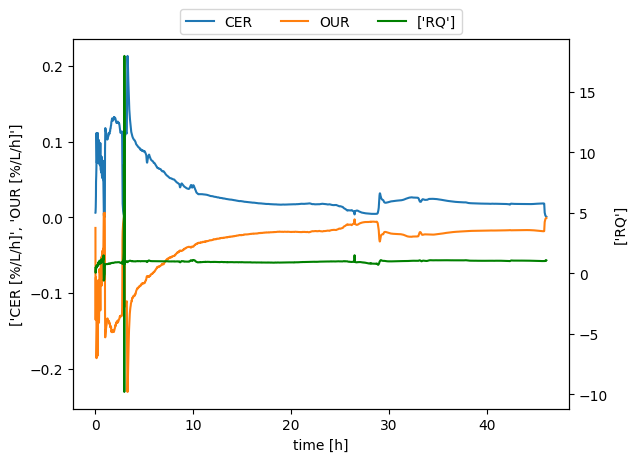

In [32]:
fig, ax = plt.subplots()

ax_sec=ax.twinx()
ax.plot(df['time [h]'], df[['CER [%/L/h]', 'OUR [%/L/h]']], label=['CER', 'OUR'])
ax_sec.plot(df['time [h]'],df['RQ'], label=['RQ'], color='green')

ax.set_xlabel('time [h]')
ax.set_ylabel(['CER [%/L/h]', 'OUR [%/L/h]'])
ax_sec.set_ylabel(['RQ'])
# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_sec.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd
all_labels = labels + labels_2nd

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=3)

plt.show()